In [2]:
# Setup notebook
from pathlib import Path
import ipywidgets as widgets
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import numpy as np
import seaborn as sns
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess

from sklearn.multioutput import RegressorChain
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBRegressor

import itertools
import warnings

import statsmodels.api as sm
from pylab import rcParams
import scipy.stats as ss

warnings.filterwarnings('ignore')
plt.style.use('fivethirtyeight')


# EDA

In [79]:
train = pd.read_csv(r'D:\train\train.csv')
test = pd.read_csv(r'D:\train\test.csv')

In [80]:
train['date'] = pd.to_datetime(train['date'])
train.rename(columns={'sales': 'Sales'}, inplace=True)
train['Year'] = train['date'].dt.year
train['Month'] = train['date'].dt.month

In [81]:
# Inspecting time series and rolling mean:

crossing = train[['date', 'Sales']].groupby('date').sum()
tseries = train.groupby(['date'])['Sales'].agg(
    ['sum']).reset_index().rename(columns={'sum': 'Sales'})
tseries = tseries.set_index('date')

In [82]:
y = tseries['Sales'].resample('MS').mean()

In [83]:
y['2017':]

date
2017-01-01    849295.481797
2017-02-01    830361.156248
2017-03-01    861419.925512
2017-04-01    863176.949652
2017-05-01    868124.104858
2017-06-01    856094.070833
2017-07-01    871337.985995
2017-08-01    828888.196052
Freq: MS, Name: Sales, dtype: float64

## Decomposing the Time Series -trend, seasonality , noise

Patterns appear when we decompose the series and plot the data. The time-series has seasonality pattern, peaking rightbefore year end. Sales had been trending upward troughout the year.

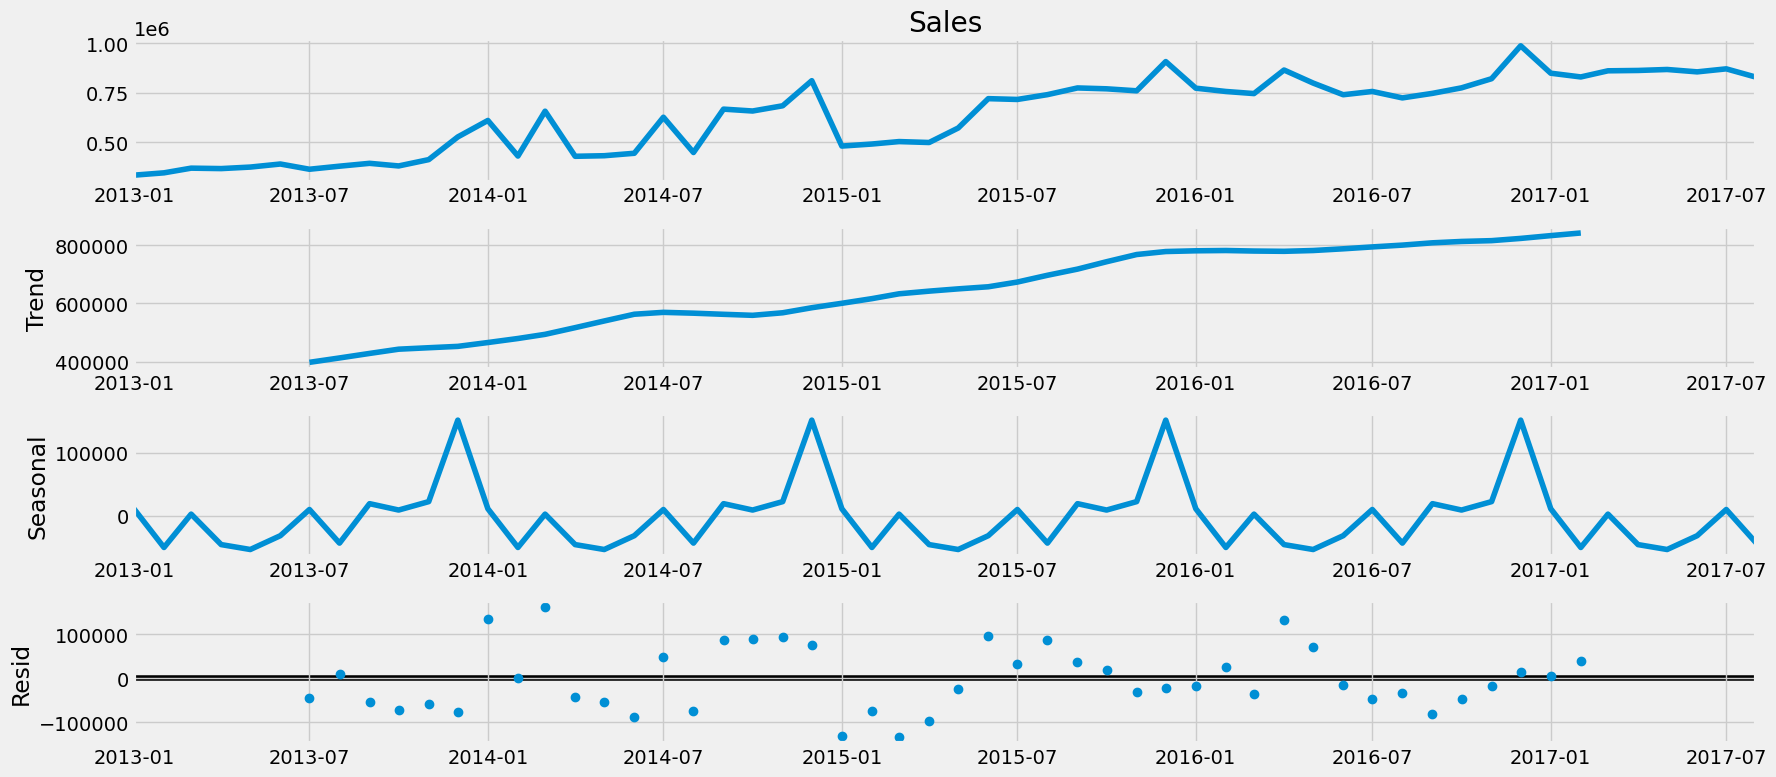

In [84]:

from pylab import rcParams
rcParams['figure.figsize'] = 18, 8

decomposition = sm.tsa.seasonal_decompose(y, model='additive')
fig = decomposition.plot()
plt.show()

# ARIMA (Seasonal ARIMA)

In [88]:
# Based on a previous run, evaluation parameters of PDQ at (1,1,0) yielded lowest MSE
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]


In [89]:
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()

            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:1633.8455129211088
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:1257.9995997912297
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:1160.7285700168436
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:2740.0175403322637
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:1171.0314611756453
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:1149.076748607287
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:857.8235781329272
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:832.5005403515293
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:1569.816495807208
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:1220.4012021621666
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:1123.9889608326312
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:2688.2164329165344
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:1270.5533693718528
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:1215.1138187567735
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:854.5417917204636
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:797.6115834999387
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:1399.346995379829
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:1126.7788284177993

## SARIMA model using pdq = (1,1,1) and P, D, Q = (1, 1, 0) with and 12 month lag

In [90]:
mod = sm.tsa.statespace.SARIMAX(y,
                                order=(1, 1, 1),
                                seasonal_order=(1, 1, 0, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()

print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9065      0.377     -2.405      0.016      -1.645      -0.168
ma.L1          0.7225      0.579      1.248      0.212      -0.412       1.857
ar.S.L12      -0.4640      0.309     -1.500      0.134      -1.070       0.142
sigma2      1.407e+10   5.88e-12   2.39e+21      0.000    1.41e+10    1.41e+10


## Validate the model using diagnostic plots

Observations: 

The residual errors fluctuate around a mean of zero and have a uniform variance.

The density plot suggest near normal distribution..

Most of the points fall in line with the red line. Distribution is not skewed. Normal data distribution is observed.

The Correlogram shows no autocorrelation on the residual errors. 

Model is a good fit to proceed to forecasting.

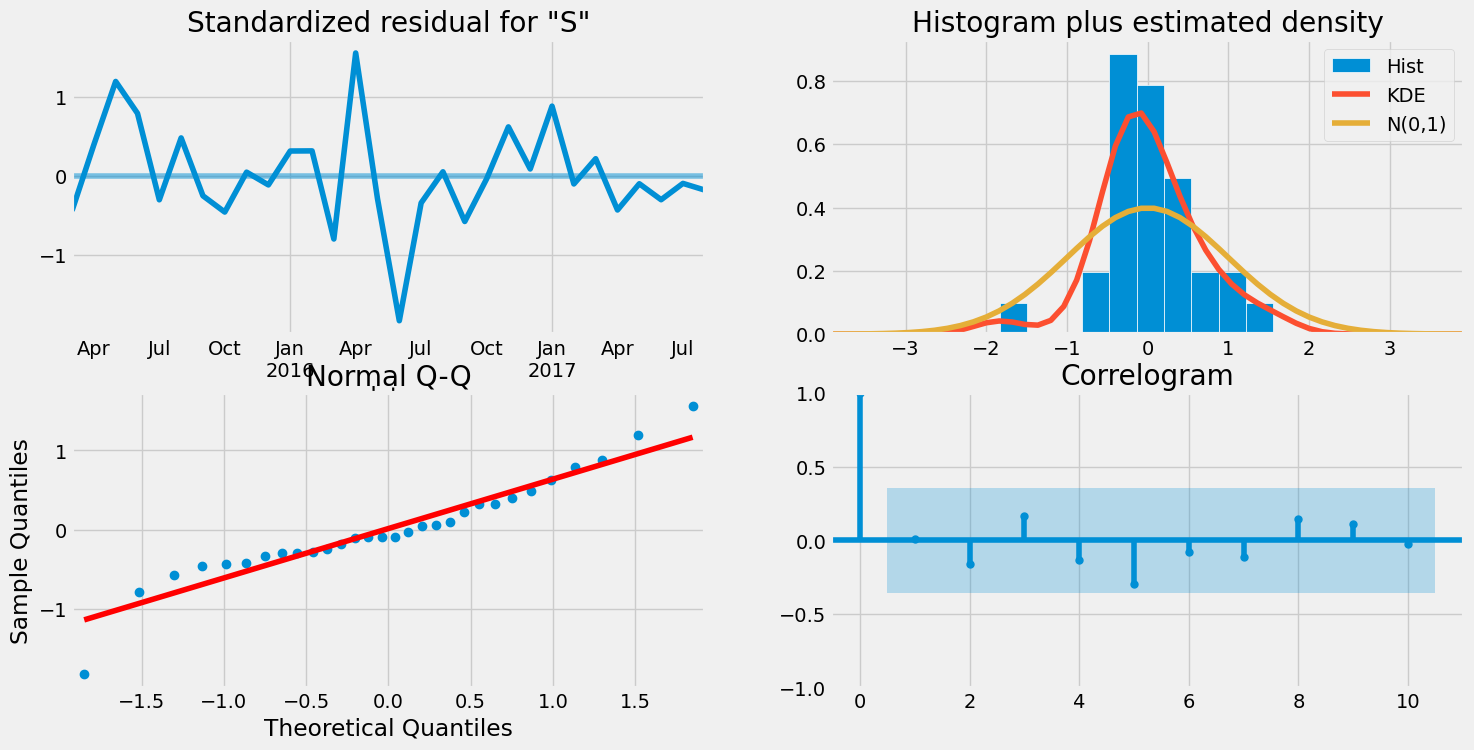

In [91]:
results.plot_diagnostics(figsize=(16, 8)) # Investigating the results:
plt.show()

## Validating forecasts:

To understand the accuracy of the forecast, predicted sales are compared to actual sales data. In the image below, forecast date is to start on 04-1-2017 to the end of the data. Based on the image below, forecast prediction looks acceptable as it follows the actual data closely.

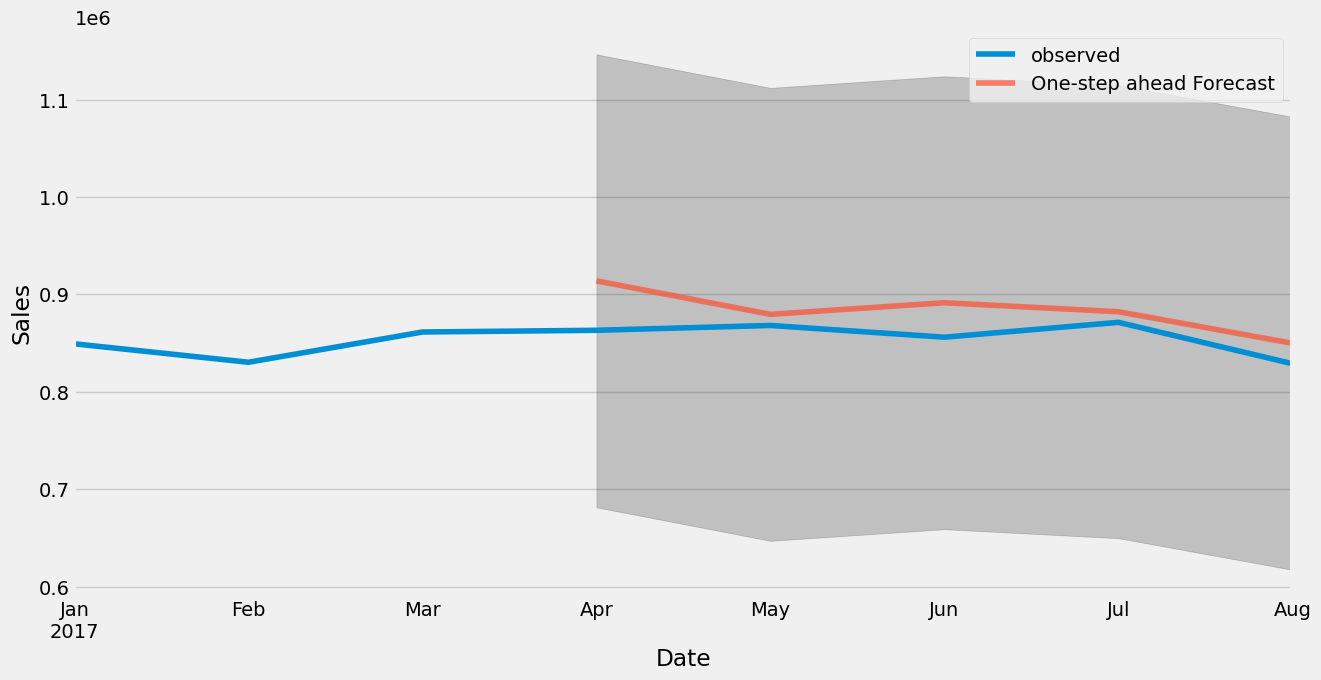

In [92]:
pred = results.get_prediction(start=pd.to_datetime('2017-04-01'), dynamic=False)
pred_ci = pred.conf_int()

ax = y['2017':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Date')
ax.set_ylabel('Sales')
plt.legend()

plt.show()

## Forecasting

Based on image below, forecast looks acceptable as it follows seasonality of a upward trend in sales shortly before year end similar to previous years.

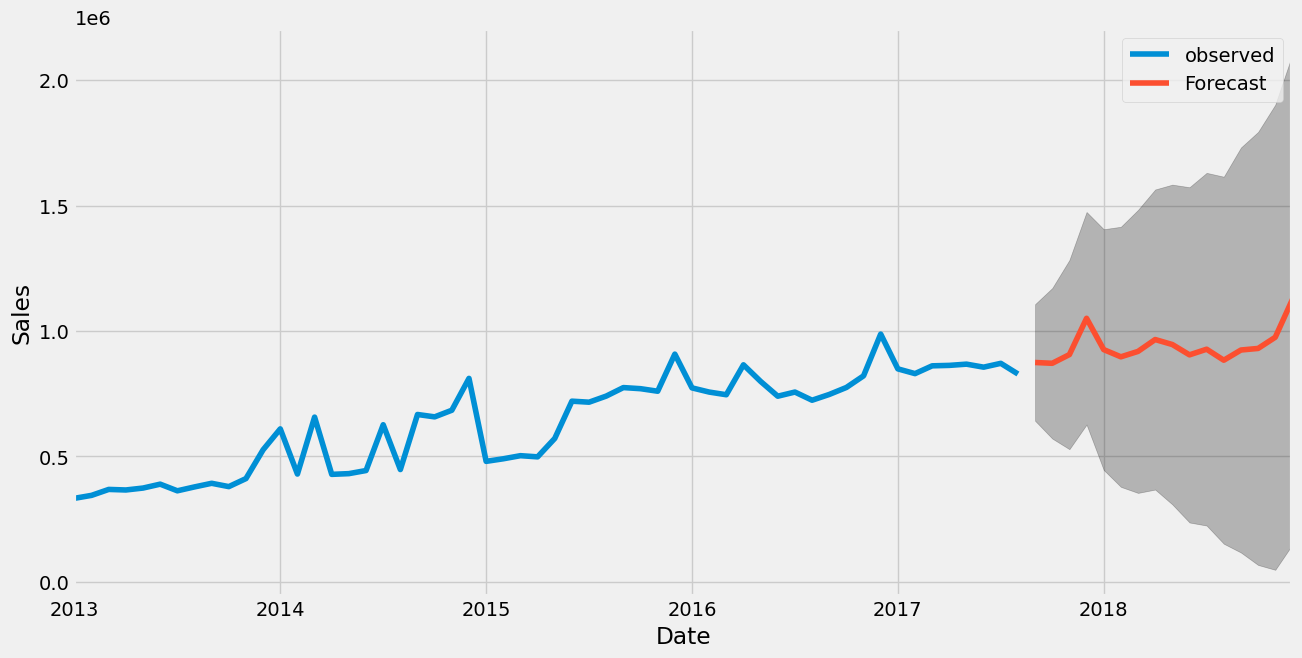

In [93]:
pred_uc = results.get_forecast(steps=16)
pred_ci = pred_uc.conf_int()

ax = y.plot(label='observed', figsize=(14, 7))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Sales')

plt.legend()
plt.show()

In [94]:
y_forecasted = pred.predicted_mean
y_truth = y['2017-01-01':]

# Calculate the mean absolute error (MAE)
mae = np.mean(np.abs(y_forecasted - y_truth))

# Compute the mean squared error (MSE)
mse = np.mean((y_forecasted - y_truth) ** 2)

# Calculate the root mean squared error (RMSE)
rmse = np.sqrt(mse)

# Print the RMSE, MSE, and MAE
print('Root Mean Squared Error (RMSE): {:.2f}'.format(rmse))
print('Mean Squared Error (MSE): {:.2f}'.format(mse))
print('Mean Absolute Error (MAE): {:.2f}'.format(mae))

Root Mean Squared Error (RMSE): 30039.16
Mean Squared Error (MSE): 902350967.44
Mean Absolute Error (MAE): 25865.46


# Data Processing for Neural Networks 

In [95]:
!pip install chart_studio

In [97]:
train_df = pd.read_csv(r'D:\train\train.csv', parse_dates=['date'])
test_df = pd.read_csv(r'D:\train\test.csv', parse_dates=['date'])

In [98]:
# Creating a instance of label Encoder.
le = LabelEncoder()
 
# Using .fit_transform function to fit label
# encoder and return encoded label
label = le.fit_transform(train_df['family'])
 
# printing label
label

array([ 0,  1,  2, ..., 30, 31, 32])

In [99]:
label2 = le.fit_transform(train_df['store_nbr'])
label2

array([0, 0, 0, ..., 8, 8, 8], dtype=int64)

In [100]:
train_df.drop(("family"), axis=1, inplace=True)
train_df.drop(("store_nbr"), axis=1, inplace=True)
 
# Appending the array to dataFrame

train_df["family"] = label
train_df["store_nbr"] = label2

In [101]:
print('Min date from train set: %s' % train_df['date'].min().date())
print('Max date from train set: %s' % train_df['date'].max().date())

Min date from train set: 2013-01-01
Max date from train set: 2017-08-15


In [102]:
lag_size = (test_df['date'].max().date() - train_df['date'].max().date()).days
print('Max date from train set: %s' % train_df['date'].max().date())
print('Max date from test set: %s' % test_df['date'].max().date())
print('Forecast lag size', lag_size)

Max date from train set: 2017-08-15
Max date from test set: 2017-08-31
Forecast lag size 16


## Transform data

Time series data has to be transformed into supervised learning data

In [103]:
train_df = train_df[(train_df['date'] >= '2017-01-01')] #working on data starting from this date

In [104]:
#Rearrange data
train_gp = train_df.sort_values('date').groupby(['family', 'store_nbr', 'date','onpromotion'], as_index=False)
train_gp = train_gp.agg({'sales':['mean']})
train_gp.columns = ['family', 'store_nbr', 'date', 'onpromotion','sales']
train_gp.head()

,family,store_nbr,date,onpromotion,sales
0,0,0,2017-01-01,0,0.0
1,0,0,2017-01-02,0,5.0
2,0,0,2017-01-03,0,4.0
3,0,0,2017-01-04,0,1.0
4,0,0,2017-01-05,0,2.0


In [105]:
# Transform series to supervised learning 

def series_to_supervised(data, window=1, lag=1, dropnan=True):
    cols, names = list(), list()
    # Input sequence (t-n, ... t-1)
    for i in range(window, 0, -1):
        cols.append(data.shift(i))
        names += [('%s(t-%d)' % (col, i)) for col in data.columns]
    # Current timestep (t=0)
    cols.append(data)
    names += [('%s(t)' % (col)) for col in data.columns]
    # Target timestep (t=lag)
    cols.append(data.shift(-lag))
    names += [('%s(t+%d)' % (col, lag)) for col in data.columns]
    # Put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # Drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [106]:
#use the current timestep and the last 29 to forecast 16 days ahead
window = 29
lag = lag_size
series = series_to_supervised(train_gp.drop('date', axis=1), window=window, lag=lag)
series.head()

,family(t-29),store_nbr(t-29),onpromotion(t-29),sales(t-29),family(t-28),store_nbr(t-28),onpromotion(t-28),sales(t-28),family(t-27),store_nbr(t-27),...,onpromotion(t-1),sales(t-1),family(t),store_nbr(t),onpromotion(t),sales(t),family(t+16),store_nbr(t+16),onpromotion(t+16),sales(t+16)
29,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,...,0.0,0.0,0,0,0,3.0,0.0,0.0,0.0,3.0
30,0.0,0.0,0.0,5.0,0.0,0.0,0.0,4.0,0.0,0.0,...,0.0,3.0,0,0,0,5.0,0.0,0.0,0.0,3.0
31,0.0,0.0,0.0,4.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,5.0,0,0,0,7.0,0.0,0.0,0.0,7.0
32,0.0,0.0,0.0,1.0,0.0,0.0,0.0,2.0,0.0,0.0,...,0.0,7.0,0,0,0,3.0,0.0,0.0,0.0,3.0
33,0.0,0.0,0.0,2.0,0.0,0.0,0.0,2.0,0.0,0.0,...,0.0,3.0,0,0,0,1.0,0.0,0.0,0.0,0.0


In [107]:
#Drop rows with different item or store values than the shifted columns

last_item = 'family(t-%d)' % window
last_store = 'store_nbr(t-%d)' % window
last_onpromotion = 'onpromotion(t-%d)' % window
series = series[(series['store_nbr(t)'] == series[last_store])]
series = series[(series['family(t)'] == series[last_item])]
series = series[(series['onpromotion(t)'] == series[last_item])]

### Split data into train and test

In [108]:
import numpy as np
from sklearn.model_selection import train_test_split

# Label
labels_col = 'sales(t+%d)' % lag_size
labels = np.array(series[labels_col])  # Convert to NumPy array
series = series.drop(labels_col, axis=1)

X_train, X_valid, Y_train, Y_valid = train_test_split(series, labels, test_size=0.2, random_state=0)
print('Train set shape:', X_train.shape)
print('Validation set shape:', X_valid.shape)
X_train.head()


Train set shape: (10364, 123)
Validation set shape: (2592, 123)


,family(t-29),store_nbr(t-29),onpromotion(t-29),sales(t-29),family(t-28),store_nbr(t-28),onpromotion(t-28),sales(t-28),family(t-27),store_nbr(t-27),...,store_nbr(t-1),onpromotion(t-1),sales(t-1),family(t),store_nbr(t),onpromotion(t),sales(t),family(t+16),store_nbr(t+16),onpromotion(t+16)
4500,0.0,19.0,0.0,7.0,0.0,19.0,0.0,3.0,0.0,19.0,...,19.0,0.0,6.0,0,19,0,3.0,0.0,19.0,0.0
9652,0.0,42.0,0.0,4.0,0.0,42.0,0.0,5.0,0.0,42.0,...,42.0,0.0,1.0,0,42,0,0.0,0.0,42.0,0.0
10976,0.0,48.0,2.0,10.0,0.0,48.0,1.0,11.0,0.0,48.0,...,48.0,0.0,10.0,0,48,0,5.0,0.0,48.0,0.0
5895,0.0,25.0,0.0,7.0,0.0,25.0,0.0,3.0,0.0,25.0,...,25.0,0.0,2.0,0,25,0,3.0,0.0,26.0,0.0
73389,5.0,53.0,7.0,198.0,5.0,53.0,6.0,187.0,5.0,53.0,...,53.0,9.0,174.0,5,53,5,149.0,5.0,53.0,34.0


# CNN

For this Convolutional Neural Network model, the number of input time steps is defined as 1 and the number of features as 2 via the input_shape argument. One convolutional hidden layer is used followed by a max pooling layer and fully-connected layer. The filter maps are then flattened before being interpreted by dense layers and output a prediction. The model uses Adam version of stochastic gradient descent and optimizes the mean squared error (‘mse‘) loss function.The model is then fit to the training data for predictions.

I used one convolutional layer with kernel size =2, stride =1, Rectified Linear Unit activation (ReLu). After the MaxPooling, data was flattened and dense layers added with activation of ReLu. The model is compiled using a loss and optimizer arguments. Dropout set at 0.2 to avoid overfitting and improve performance.

In [109]:
pip install tensorflow


In [3]:
!pip install tensorflow


In [ ]:
import tensorflow as tf


In [ ]:
from keras.optimizers import Adam
# Set parameters
epochs = 1000
batch = 128
lr = 0.00001
adam = optimizers.Adam(lr)

### Reshape for CNN 

In [ ]:
X_train_series = X_train.values.reshape((X_train.shape[0], X_train.shape[1], 1))
X_valid_series = X_valid.values.reshape((X_valid.shape[0], X_valid.shape[1], 1))
print('Train set shape', X_train_series.shape)
print('Validation set shape', X_valid_series.shape)

In [ ]:
cnn = Sequential()
cnn.add(Conv1D(filters=128, kernel_size=2, activation='relu', input_shape=(X_train_series.shape[1], X_train_series.shape[2])))
cnn.add(MaxPooling1D(pool_size=2))
cnn.add(Flatten())
cnn.add(Dense (128, activation='relu'))
cnn.add(Dropout(0.2))
cnn.add(Dense (128, activation='relu'))
cnn.add(Dropout(0.2))
cnn.add(Dense (34, activation='relu'))
cnn.add(Dropout(0.2))
cnn.add(Dense(1))
cnn.compile(loss='mse', optimizer=adam)
cnn.summary()

In [39]:
import tensorflow as tf
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

In [40]:
cnn_history = cnn.fit(X_train_series, Y_train, validation_data=(X_valid_series, Y_valid), callbacks=[callback],epochs=epochs, verbose=2)

Epoch 1/1000
324/324 - 3s - loss: 91585.7500 - val_loss: 62965.6680 - 3s/epoch - 10ms/step
Epoch 2/1000
324/324 - 2s - loss: 60054.9336 - val_loss: 43705.3594 - 2s/epoch - 7ms/step
Epoch 3/1000
324/324 - 2s - loss: 41557.2812 - val_loss: 27295.2344 - 2s/epoch - 7ms/step
Epoch 4/1000
324/324 - 2s - loss: 29547.8867 - val_loss: 13913.3984 - 2s/epoch - 6ms/step
Epoch 5/1000
324/324 - 2s - loss: 21067.6094 - val_loss: 8207.3955 - 2s/epoch - 7ms/step
Epoch 6/1000
324/324 - 2s - loss: 17512.0664 - val_loss: 7585.3003 - 2s/epoch - 6ms/step
Epoch 7/1000
324/324 - 2s - loss: 16412.6074 - val_loss: 7312.2729 - 2s/epoch - 6ms/step
Epoch 8/1000
324/324 - 2s - loss: 15349.1719 - val_loss: 6997.8833 - 2s/epoch - 6ms/step
Epoch 9/1000
324/324 - 2s - loss: 17155.4258 - val_loss: 6937.1499 - 2s/epoch - 6ms/step
Epoch 10/1000
324/324 - 2s - loss: 16845.7188 - val_loss: 7052.7949 - 2s/epoch - 6ms/step
Epoch 11/1000
324/324 - 2s - loss: 14443.5410 - val_loss: 6731.1831 - 2s/epoch - 6ms/step
Epoch 12/1000


# LSTM


For Long Short-Term Memory Neural Network, a recurrent neural network model, the number of input time steps is defined as 1 and the number of features as 2 via the input_shape argument.

This will use one LSTM layer to process input sub-sequence of the time step, followed by dense layers to interpret the summary of the input sequence. The model uses the efficient Adam version of stochastic gradient descent and optimizes the mean squared error (‘mse‘) loss function.

The model is then fit to the training data for predictions.

In [41]:
epochs = 1000
batch = 128
lr = 0.00001
adam = optimizers.Adam(lr)

In [42]:
lstm = Sequential()
lstm.add(LSTM(256, activation='relu', input_shape=(X_train_series.shape[1], X_train_series.shape[2])))
lstm.add(Dense(128))
lstm.add(Dropout(0.2))
lstm.add(Dense(64))
lstm.add(Dense(32))
lstm.add(Dense(1))
lstm.compile(loss='mse', optimizer=adam)
lstm.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 256)               264192    
                                                                 
 dense_4 (Dense)             (None, 128)               32896     
                                                                 
 dropout_3 (Dropout)         (None, 128)               0         
                                                                 
 dense_5 (Dense)             (None, 64)                8256      
                                                                 
 dense_6 (Dense)             (None, 32)                2080      
                                                                 
 dense_7 (Dense)             (None, 1)                 33        
                                                                 
Total params: 307,457
Trainable params: 307,457
Non-tr

In [43]:
import tensorflow as tf
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

In [44]:
lstm_history = lstm.fit(X_train_series, Y_train, validation_data=(X_valid_series, Y_valid),callbacks=[callback], epochs=epochs, verbose=2)

Epoch 1/1000
324/324 - 23s - loss: 36164.1172 - val_loss: 23922.4395 - 23s/epoch - 71ms/step
Epoch 2/1000
324/324 - 21s - loss: 22157.6094 - val_loss: 15218.0879 - 21s/epoch - 66ms/step
Epoch 3/1000
324/324 - 21s - loss: 19617.5645 - val_loss: 14269.7002 - 21s/epoch - 66ms/step
Epoch 4/1000
324/324 - 22s - loss: 27921.1758 - val_loss: 19254.7051 - 22s/epoch - 67ms/step
Epoch 5/1000
324/324 - 21s - loss: 25463.2871 - val_loss: 16406.6387 - 21s/epoch - 66ms/step
Epoch 6/1000
324/324 - 22s - loss: 18278.4355 - val_loss: 14254.1006 - 22s/epoch - 67ms/step
Epoch 7/1000
324/324 - 22s - loss: 17814.1465 - val_loss: 12524.1680 - 22s/epoch - 67ms/step
Epoch 8/1000
324/324 - 21s - loss: 16779.2480 - val_loss: 14965.0879 - 21s/epoch - 65ms/step
Epoch 9/1000
324/324 - 22s - loss: 16395.6465 - val_loss: 12559.3037 - 22s/epoch - 66ms/step
Epoch 10/1000
324/324 - 21s - loss: 20659.2949 - val_loss: 16195.6699 - 21s/epoch - 66ms/step
Epoch 11/1000
324/324 - 21s - loss: 17872.9707 - val_loss: 10496.9561

# CNN-LSTM


According to some research, this hybrid model is more efficient in predictions, precisions and stability as it merges CNN and LTSM learning architectures.

In this hybrid model, each sample is divided into subsequences where CNN will read each subsequence and LSTM will read the interpretations from these subsequences.

This CNN which has 2 timesteps per subsequence and 1 feature is wrapped (in TimeDistributed) which applies a layer to every temporal slice of an input.

The LSTM interprets the results before the model makes a prediction.

The model uses the efficient Adam version of stochastic gradient descent and optimizes the mean squared error (‘mse‘) loss function.

In [45]:
epochs = 1000
batch = 128
lr = 0.00001
adam = optimizers.Adam(lr)

### Reshape data for CNN-LSTM

In [46]:
subsequences = 1
timesteps = X_train_series.shape[1]//subsequences
X_train_series_sub = X_train_series.reshape((X_train_series.shape[0], subsequences, timesteps, 1))
X_valid_series_sub = X_valid_series.reshape((X_valid_series.shape[0], subsequences, timesteps, 1))
print('Train set shape', X_train_series_sub.shape)
print('Validation set shape', X_valid_series_sub.shape)

Train set shape (10364, 1, 31, 1)
Validation set shape (2592, 1, 31, 1)


In [47]:
cnn_lstm = Sequential()
cnn_lstm.add(TimeDistributed(Conv1D(filters=128, kernel_size=1, activation='relu'), input_shape=(None, X_train_series_sub.shape[2], X_train_series_sub.shape[3])))
cnn_lstm.add(TimeDistributed(MaxPooling1D(pool_size=2)))
cnn_lstm.add(TimeDistributed(Flatten()))
cnn_lstm.add(TimeDistributed(Dropout(0.2)))
cnn_lstm.add(LSTM(64, activation='relu'))
cnn_lstm.add(Dense(32))
cnn_lstm.add(Dense(1))
cnn_lstm.compile(loss='mse', optimizer=adam)

In [48]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

In [49]:
cnn_lstm_history = cnn_lstm.fit(X_train_series_sub, Y_train, validation_data=(X_valid_series_sub, Y_valid),callbacks=[callback], epochs=epochs, verbose=2)

Epoch 1/1000
324/324 - 5s - loss: 53781.6211 - val_loss: 22044.2578 - 5s/epoch - 15ms/step
Epoch 2/1000
324/324 - 3s - loss: 13627.1572 - val_loss: 8063.9868 - 3s/epoch - 9ms/step
Epoch 3/1000
324/324 - 3s - loss: 10737.8096 - val_loss: 7630.6128 - 3s/epoch - 9ms/step
Epoch 4/1000
324/324 - 3s - loss: 10500.1514 - val_loss: 7242.6001 - 3s/epoch - 9ms/step
Epoch 5/1000
324/324 - 3s - loss: 9680.3887 - val_loss: 6721.7114 - 3s/epoch - 9ms/step
Epoch 6/1000
324/324 - 3s - loss: 9033.0830 - val_loss: 6631.2285 - 3s/epoch - 9ms/step
Epoch 7/1000
324/324 - 3s - loss: 9742.2852 - val_loss: 6644.1001 - 3s/epoch - 9ms/step
Epoch 8/1000
324/324 - 3s - loss: 9203.7490 - val_loss: 6518.1328 - 3s/epoch - 9ms/step
Epoch 9/1000
324/324 - 3s - loss: 9630.3818 - val_loss: 5966.1167 - 3s/epoch - 9ms/step
Epoch 10/1000
324/324 - 3s - loss: 8391.9502 - val_loss: 5938.7959 - 3s/epoch - 9ms/step
Epoch 11/1000
324/324 - 3s - loss: 8441.9414 - val_loss: 5766.9146 - 3s/epoch - 9ms/step
Epoch 12/1000
324/324 - 

# Evaluate Learning Curves

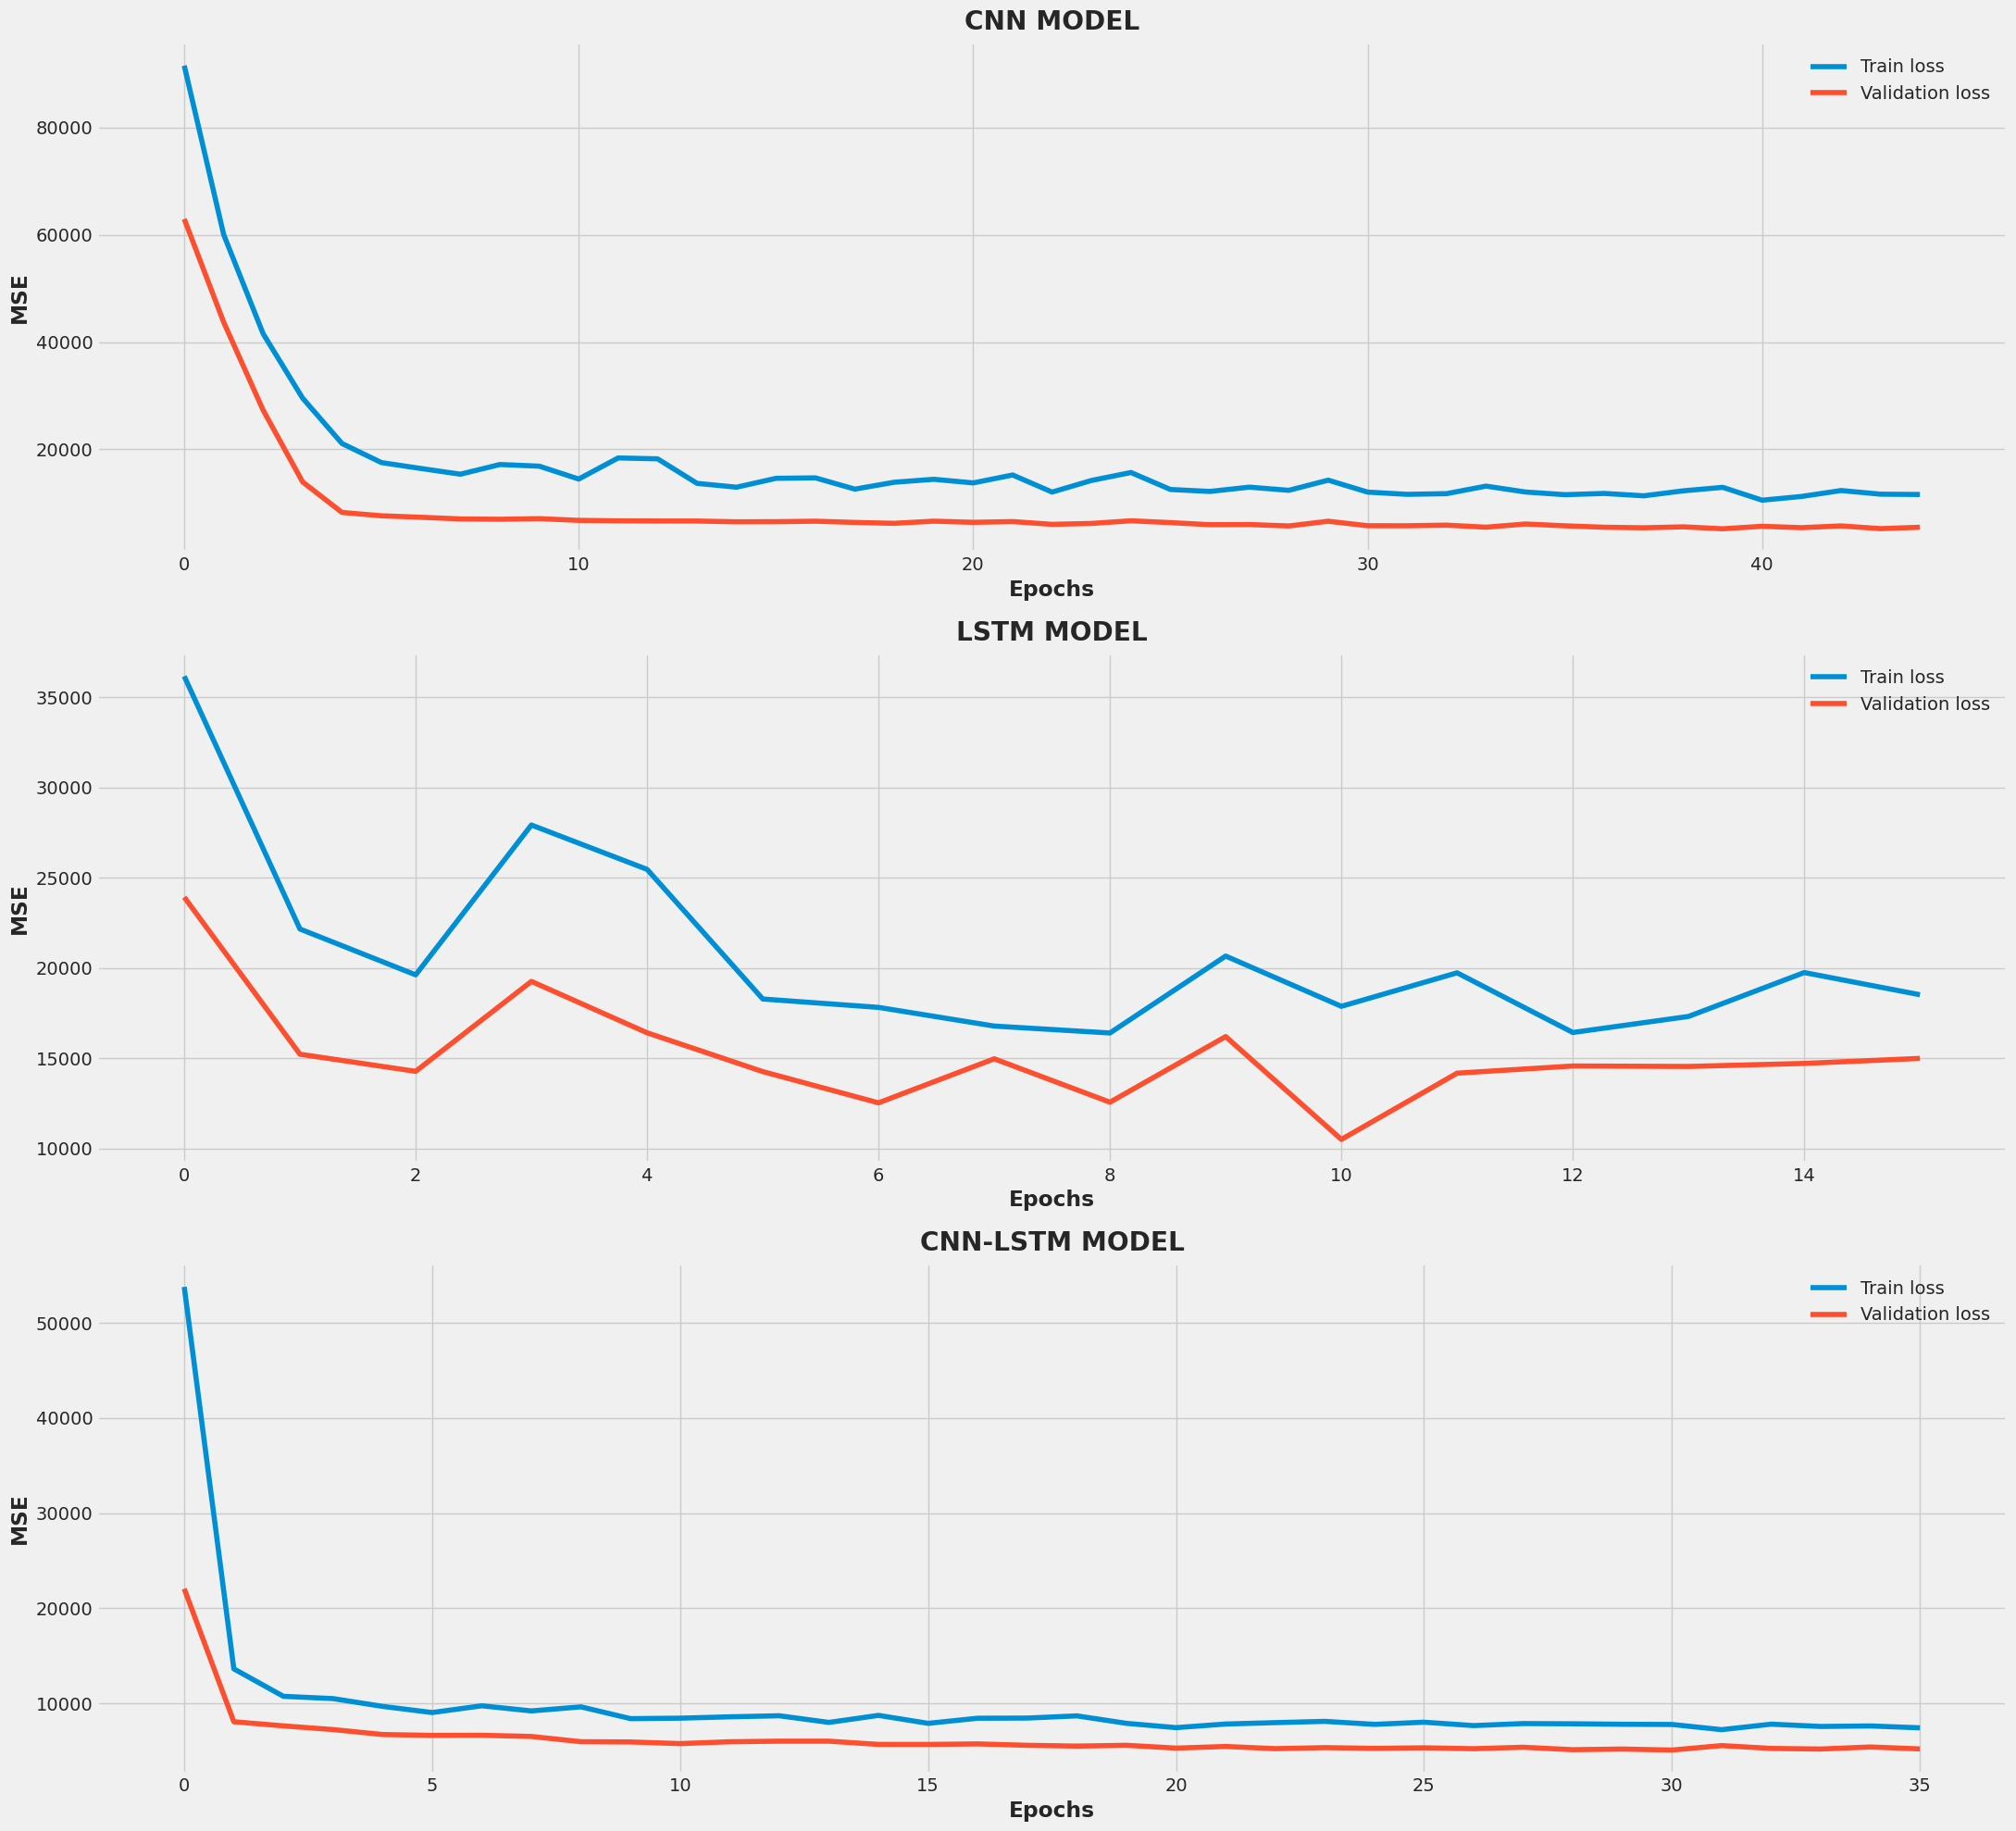

In [50]:
fig, axes = plt.subplots(3, 1, sharey=False,figsize=(22,20))
ax1 = axes[0]
ax2 = axes[1]
ax3 = axes[2]


ax1.plot(cnn_history.history['loss'], label='Train loss')
ax1.plot(cnn_history.history['val_loss'], label='Validation loss')
ax1.legend(loc='best')
ax1.set_title('CNN MODEL')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('MSE')

ax2.plot(lstm_history.history['loss'], label='Train loss')
ax2.plot(lstm_history.history['val_loss'], label='Validation loss')
ax2.legend(loc='best')
ax2.set_title('LSTM MODEL')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('MSE')

ax3.plot(cnn_lstm_history.history['loss'], label='Train loss')
ax3.plot(cnn_lstm_history.history['val_loss'], label='Validation loss')
ax3.legend(loc='best')
ax3.set_title('CNN-LSTM MODEL')
ax3.set_xlabel('Epochs')
ax3.set_ylabel('MSE')

plt.show()

# Evaluate RMSE

In [51]:
cnn_train_pred = cnn.predict(X_train_series)
cnn_valid_pred = cnn.predict(X_valid_series)
print('Train CNN rmse:', np.sqrt(mean_squared_error(Y_train, cnn_train_pred)))
print('Validation CNN rmse:', np.sqrt(mean_squared_error(Y_valid, cnn_valid_pred)))

81/81 [==============================] - 0s 2ms/step
Train CNN rmse: 84.1204921824048
Validation CNN rmse: 73.80347482759832


In [52]:
lstm_train_pred = lstm.predict(X_train_series)
lstm_valid_pred = lstm.predict(X_valid_series)
print('Train LSTM rmse:', np.sqrt(mean_squared_error(Y_train, lstm_train_pred)))
print('Validation LSTM rmse:', np.sqrt(mean_squared_error(Y_valid, lstm_valid_pred)))

81/81 [==============================] - 2s 23ms/step
Train LSTM rmse: 125.70460865422689
Validation LSTM rmse: 122.42091750903457


In [53]:
cnn_lstm_train_pred = cnn_lstm.predict(X_train_series_sub)
cnn_lstm_valid_pred = cnn_lstm.predict(X_valid_series_sub)
print('Train CNN-LSTM rmse:', np.sqrt(mean_squared_error(Y_train, cnn_lstm_train_pred)))
print('Validation CNN-LSTM rmse:', np.sqrt(mean_squared_error(Y_valid, cnn_lstm_valid_pred)))

81/81 [==============================] - 0s 3ms/step
Train CNN-LSTM rmse: 85.50672708817729
Validation CNN-LSTM rmse: 72.16673701223283
